In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
from vae_lib.utils.norm_dist import NormDist
from vae_lib.utils.norm_dist_diag import NormDistDiag
from vae_lib.utils.gmm_on_circle import MixtureOfNormalsOnCircle
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle

In [2]:
# Set Eager API
print("Setting Eager mode...")
tf.enable_eager_execution()
tfe = tf.contrib.eager

Setting Eager mode...


In [3]:
def plot_normal(mean, cov):
    x, y = np.random.multivariate_normal(mean, cov, 5000).T
    plt.plot(x, y, 'x')
    plt.axis('equal')
    plt.tight_layout()
    #plt.axis('off')
    #plt.axes().set_aspect('equal', 'datalim')
    plt.show()

In [4]:
def get_sample(params):
    s = np.random.multivariate_normal(params.mean, params.cov, 1)[0].T
    return s

In [5]:
def generate_samples_from_gmm(norm_params, weights, N):
    mixture_idx = np.random.choice(len(weights), size=N, replace=True, p=weights)
    samples = [norm_params[i].rvs(size=1) for i in mixture_idx]
    return np.array(samples)

In [6]:
# z = tf.constant([[1., 4.],
#                  [3.,1.],
#                  [2.,3.],
#                  [0.5,0.5],
#                  [0.2,2.1]
#                 ],name='z')
#z = tf.constant([[1., 4.]],name='z')
# z = tf.constant([mean1,
#                  mean2,
#                  mean3,
#                  mean4,
#                  mean5,
#                  mean6,
#                  mean7,
#                  mean8],name='z')

In [7]:
init_cov = np.array([
        [0.7,0.0],
        [0.0,0.07]
    ], dtype="float64")

# init_cov = np.array([
#         [7,0.0],
#         [0.0,0.7]
#     ], dtype="float64")

mix = MixtureOfNormalsOnCircle(10, init_cov, r=2.5)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

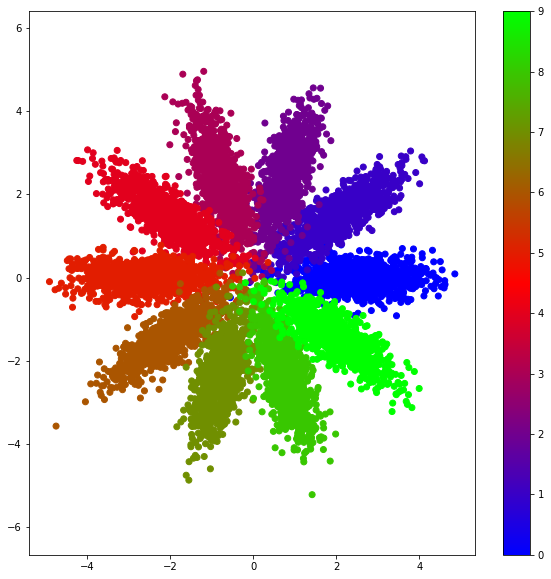

In [8]:
plt.figure(figsize=(10,10))
mix.generate_and_plot(1000)

In [9]:
dists = mix.get_dists()

In [10]:
# # z = tf.constant([mean1],name='z')
# z = tf.constant([mean1,
#                  mean2,
#                  mean3,
#                  mean4,
#                  mean5,
#                  mean6,
#                  mean7,
#                  mean8],name='z')
# z.shape

In [11]:
probs = tf.stack([dist.prob(z) for dist in dists])
probs     

NameError: name 'z' is not defined

In [ ]:
denom = tf.reduce_sum(betas * probs, axis=0)
#denom = tf.reshape(denom, (-1, 1))
denom

In [ ]:
resp = probs/denom*betas
tf.transpose(resp)

In [ ]:
tf.reduce_sum(resp, axis=0)

In [ ]:
mix.responsibilities(z)

In [ ]:
tf_dists = mix.get_tf_dists()

In [ ]:
z

In [ ]:
probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in tf_dists])

In [ ]:
betas = (0.5 * np.ones(10)).reshape((10,1))
betas

In [ ]:
mix.penalty_term_with_gd(z)

In [ ]:
def dists_from_angles(thetas, init_cov,r):
    cx,cy=0,0
    
    def dist_from_angle(theta, init_cov,r):
        mean_1 = cx + r * tf.math.cos(theta)
        mean_2 = cx + r * tf.math.sin(theta)
        mean = np.array([mean_1, mean_2], dtype="float64")
        u = np.array([
            [tf.math.cos(theta),-tf.math.sin(theta)],
            [tf.math.sin(theta),tf.math.cos(theta)]
        ], dtype="float64") 

        cov_rotated = tf.matmul(tf.matmul(u,init_cov),tf.transpose(u))
        tf_mean, tf_stdev = tf.constant(mean), tf.constant(cov_rotated)
        tf_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(loc=tf_mean, covariance_matrix=tf_stdev)
        return tf_dist   

    dists = [dist_from_angle(theta, init_cov,r) for theta in thetas]
    return dists

In [ ]:
def penalty_term_with_gd_only_tf(z, angles, init_cov,r):
    tf_dists = dists_from_angles(angles, init_cov,r)
    probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in tf_dists])
    betas = tf.convert_to_tensor((np.ones(10)/10).reshape((10,1)), dtype=tf.float32)
    denom = tf.reduce_sum(betas * probs, axis=0)
    denom = tf.reshape(denom, (-1, 1))

    y=-tf.reduce_sum(tf.log(1e-30 + denom))

    return y

In [ ]:
init_cov = np.array([
    [7.0,0.0],
    [0.0,0.7]
], dtype="float64")

In [ ]:
thetas = tf.constant([(2*i*np.pi)/10 for i in range(10)])
penalty_term_with_gd_only_tf(z,thetas,init_cov,r=20)

In [ ]:
tf.reset_default_graph() 

init_cov = np.array([
    [0.007,0.0],
    [0.0,0.0007]
], dtype="float64")
ex_mean = tf.convert_to_tensor([1.0,0.0], dtype=tf.float64)

z = tf.constant([[1., 4.],
                 [3., 1.],
                 [2., 3.],
                 [0.5, 0.5],
                 [0.2, 2.1]
                 ], name='z')

init_angles = [(2 * i * np.pi) / 10 for i in range(10)]
thetas = tf.get_variable(initializer=init_angles, name="thetas")

d_gmm = DynamicGmmOnCircle(tf.unstack(thetas), init_cov, r=1, K=10)
cost = d_gmm.penalty_term_with_gd_only_tf(z)
print(cost)

In [ ]:
n=3
tf.concat([np.c_[dist.sample(sample_shape=[n]),i*np.ones(n)] for i, dist in enumerate(d_gmm.dists_from_angles())], axis=0)




In [ ]:
tf.concat([dist.sample(sample_shape=[3]) for dist in d_gmm.dists_from_angles()], axis=0)

In [ ]:
samples = d_gmm.generate_samples(n=1000)

In [ ]:
tf_dist_1 = tf.contrib.distributions.MultivariateNormalFullCovariance(loc=ex_mean, covariance_matrix=init_cov)
tf_dist_2 = tf.contrib.distributions.MultivariateNormalFullCovariance(loc=tf.convert_to_tensor([-1.0,0.0], dtype=tf.float64), covariance_matrix=init_cov)



In [ ]:
sss1 = tf_dist_1.sample(sample_shape=[3])
sss2 = tf_dist_2.sample(sample_shape=[3])

sss1

In [ ]:
sss2

In [ ]:
t = tf.concat([sss1, sss2], axis=0)
t

In [6]:
def plot_samples(samples):
    plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 2], cmap='brg')
    plt.colorbar()
    # plt.plot(samples[:,0], samples[:,1], 'ro')
    plt.axis('equal')
    plt.show()

In [146]:
init_cov = np.array([
    [0.7,0.0],
    [0.0,0.07]
], dtype="float64")

z = tf.constant([[1., 4.],
                 [3., 1.],
                 [2., 3.],
                 [0.5, 0.5],
                 [0.2, 2.1]
                 ], name='z')

In [147]:

K=2
init_angles = [(2 * i * np.pi) / K for i in range(K)]
thetas = tf.get_variable(initializer=init_angles, name="thetas")

d_gmm = DynamicGmmOnCircle(tf.unstack(thetas), init_cov, r=0.8, K=K)
samples = d_gmm.generate_samples(100)

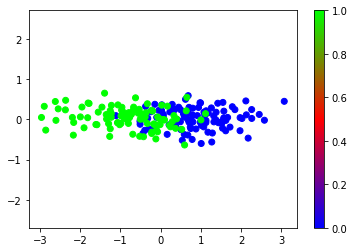

In [148]:
plot_samples(samples)

In [149]:
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
K=3
init_angles = [(2 * i * np.pi) / K for i in range(K)]
thetas = tf.get_variable(initializer=init_angles, name="thetas")
s_gmm = StaticGmmOnCircle(tf.unstack(thetas), init_cov, r=0.8, K=K)
d_gmm = DynamicGmmOnCircle(tf.unstack(thetas), init_cov, r=0.8, K=K)

In [150]:
tf.reshape(s_gmm.penalty_term_with_gd_only_tf(z), [])

<tf.Tensor: id=33474, shape=(), dtype=float32, numpy=68.69978>

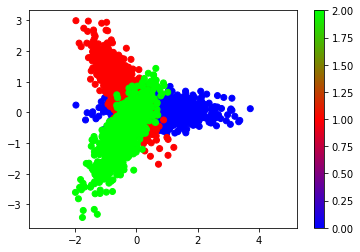

In [111]:
samples = s_gmm.generate_samples(1000)
plot_samples(samples)

In [112]:
# z = [[-1.0 , 0. ]]
z = tf.constant([[1., 4.],
                 [3., 1.],
                 [2., 3.],
                 [0.5, 0.5],
                 [0.2, 2.1]
                 ], name='z')

In [113]:
probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in s_gmm.tf_dists], axis=1)


In [114]:
probs

<tf.Tensor: id=28849, shape=(5, 3), dtype=float32, numpy=
array([[0.0000000e+00, 8.3735130e-28, 6.7142051e-12],
       [1.7914332e-05, 2.7836701e-31, 1.2360484e-17],
       [3.0980485e-29, 1.7951252e-33, 4.8894384e-07],
       [1.1305175e-01, 1.9565107e-02, 1.1764334e-01],
       [1.1608375e-14, 8.9839132e-06, 1.5105432e-05]], dtype=float32)>

In [115]:
betas = tf.convert_to_tensor((np.ones(K) / K).reshape((1, K)), dtype=tf.float32)
betas

<tf.Tensor: id=28851, shape=(1, 3), dtype=float32, numpy=array([[0.33333334, 0.33333334, 0.33333334]], dtype=float32)>

In [116]:
log_probs = tf.log(1e-30+probs)
log_probs

<tf.Tensor: id=28855, shape=(5, 3), dtype=float32, numpy=
array([[-69.07755  , -62.346115 , -25.726795 ],
       [-10.92991  , -68.83197  , -38.932026 ],
       [-65.61243  , -69.07576  , -14.531018 ],
       [ -2.1799097,  -3.9340076,  -2.1400979],
       [-32.08705  , -11.620075 , -11.100456 ]], dtype=float32)>

In [117]:
log_betas = tf.log(betas)
log_betas

<tf.Tensor: id=28857, shape=(1, 3), dtype=float32, numpy=array([[-1.0986123, -1.0986123, -1.0986123]], dtype=float32)>

In [118]:
log_betas + log_probs

<tf.Tensor: id=28859, shape=(5, 3), dtype=float32, numpy=
array([[-70.17616  , -63.44473  , -26.825407 ],
       [-12.0285225, -69.93058  , -40.03064  ],
       [-66.71104  , -70.17437  , -15.629631 ],
       [ -3.278522 ,  -5.03262  ,  -3.2387102],
       [-33.185665 , -12.718687 , -12.199068 ]], dtype=float32)>

<tf.Tensor: id=28869, shape=(3, 5), dtype=float32, numpy=
array([[-70.17616  , -12.0285225, -66.71104  ,  -3.278522 , -33.185665 ],
       [-63.44473  , -69.93058  , -70.17437  ,  -5.03262  , -12.718687 ],
       [-26.825407 , -40.03064  , -15.629631 ,  -3.2387102, -12.199068 ]],
      dtype=float32)>

In [122]:
probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in s_gmm.tf_dists], axis=1)

betas = tf.convert_to_tensor((np.ones(K) / K).reshape((1, K)), dtype=tf.float32)

log_probs = tf.log(1e-30+probs)
log_betas = tf.log(1e-30+betas)
tf.transpose(log_betas + log_probs)
log_prob_for_cases = tf.matmul(labels, tf.transpose(log_betas + log_probs))
log_prob = tf.reduce_sum(log_prob_for_cases)

NameError: name 'labels' is not defined

In [143]:
def penalty_term_supervised(z, labels):
    probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in s_gmm.tf_dists], axis=1)

    betas = tf.convert_to_tensor((np.ones(K) / K).reshape((1, K)), dtype=tf.float32)

    log_probs = tf.log(1e-30+probs)
    log_betas = tf.log(1e-30+betas)
    prob_for_single_gauss = tf.transpose(log_betas + log_probs)
    log_prob_for_cases = tf.matmul(labels, prob_for_single_gauss)
    log_prob = tf.reduce_sum(log_prob_for_cases)
    return log_prob

In [144]:
labels = tf.constant([[0., 1.,0.],
                 [0., 1.,0.],
                 [1., 0.,0.],
                 [1.0, 0.0,0.],
                 [0.0, 1.0,0.]
                 ], name='l')
labels

<tf.Tensor: id=31940, shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [145]:
penalty_term_supervised(z,labels)

<tf.Tensor: id=32225, shape=(), dtype=float32, numpy=-1034.6627>

In [139]:
probs = tf.stack([tf.cast(dist.prob(tf.cast(z, tf.float64)), tf.float32) for dist in s_gmm.tf_dists], axis=1)
betas = tf.convert_to_tensor((np.ones(K) / K).reshape((1, K)), dtype=tf.float32)
log_probs = tf.log(1e-30+probs)
log_betas = tf.log(1e-30+betas)
prob_for_single_gauss = tf.transpose(log_betas + log_probs)
prob_for_single_gauss

<tf.Tensor: id=31640, shape=(3, 5), dtype=float32, numpy=
array([[-70.17616  , -12.0285225, -66.71104  ,  -3.278522 , -33.185665 ],
       [-63.44473  , -69.93058  , -70.17437  ,  -5.03262  , -12.718687 ],
       [-26.825407 , -40.03064  , -15.629631 ,  -3.2387102, -12.199068 ]],
      dtype=float32)>

In [ ]:

    
    
    log_prob_for_cases = tf.matmul(labels, tf.transpose(log_betas + log_probs))
    log_prob = tf.reduce_sum(log_prob_for_cases)